<a href="https://colab.research.google.com/github/Omar-Ouardighi/Seismic-Fault-Mapping-/blob/main/Fault_Mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install segyio

     |████████████████████████████████| 83 kB 1.6 MB/s 


In [3]:
import segyio
from matplotlib import pyplot as plt
import numpy as np

In [4]:
filename_pp = "drive/MyDrive/Equinor synthetic model/issap20_Pp.sgy"
filename_ai = "drive/MyDrive/Equinor synthetic model/issap20_AI.sgy"
filename_fault = "drive/MyDrive/Equinor synthetic model/issap20_Fault.sgy"

In [5]:
# Note: the the xline header info location is at segyio.su.cdpx [181]
def segy2numpy(filename: str) -> np.array:
    with segyio.open(filename, xline=181) as segyfile:
        return segyio.tools.cube(segyfile)

seismic = segy2numpy(filename_pp)
ai = segy2numpy(filename_ai)
fault = segy2numpy(filename_fault)

In [6]:
f"Number of inlines: {seismic.shape[0]}, crosslines: {seismic.shape[1]}, samples: {seismic.shape[2]}"

'Number of inlines: 101, crosslines: 589, samples: 751'

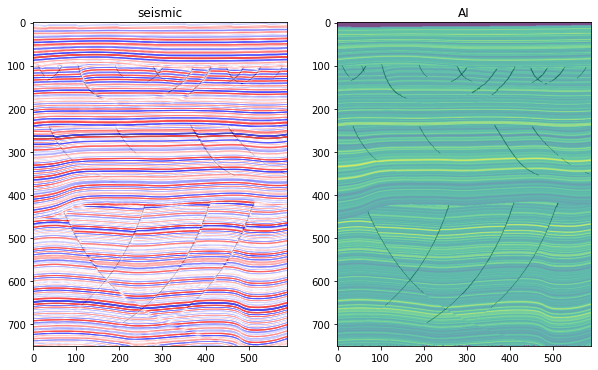

In [7]:
# plot inline
ILINE=10
plt.figure(figsize=(10, 10))
title = ['seismic', 'AI']
cmaps = ["seismic", None]

for i, cube in enumerate([seismic, ai]):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(cube[ILINE,:, :].T, cmap=cmaps[i])
    plt.imshow(fault[ILINE,:, :].T, cmap='Greys',  vmin=0, vmax=1, alpha=0.3)
    plt.axis()
plt.show()

In [8]:
import tensorflow as tf
from keras.layers import Conv2D,Dense,Activation, MaxPooling2D, Dropout, concatenate,Conv2DTranspose,Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Lambda, RepeatVector, Reshape


In [9]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3):
    x= input_tensor
    for i in range(2):
        x = Conv2D(filters = n_filters, kernel_size =(kernel_size,kernel_size),padding="same")(x)
        x = Activation('relu')(x)
    return x

def encoder_block(inputs, n_filters, pool_size, dropout):
    f = conv2d_block(inputs, n_filters)
    p=  MaxPooling2D(pool_size)(f)
    p = Dropout(dropout)(p)
    return f,p

def encoder(inputs):
    f1, p1 = encoder_block(inputs, n_filters=32, pool_size=(2,2), dropout=0.3)
    f2, p2 = encoder_block(p1, n_filters=64, pool_size=(2,2), dropout=0.3)
    f3, p3 = encoder_block(p2, n_filters=128, pool_size=(2,2), dropout=0.3)
    f4, p4 = encoder_block(p3, n_filters=256, pool_size=(2,2), dropout=0.3)
    return p4 , (f1,f2,f3,f4)

def bottleneck(inputs):
    bottle_neck = conv2d_block(inputs, n_filters=512)
    return bottle_neck


In [10]:
def decoder_block(inputs,conv_output, n_filters,kernel_size,strides,dropout):
    u = Conv2DTranspose(n_filters,kernel_size, strides=strides,padding="same")(inputs)
    c = concatenate([u, conv_output])
    c = Dropout(dropout)(c)
    c = conv2d_block(c, n_filters, kernel_size=3)
    return c

def decoder(inputs,convs):
    f1,f2,f3,f4 = convs
    c6 = decoder_block(inputs,f4, n_filters=256,kernel_size=(3,3),strides=(2,2),dropout=0.3)
    c7 = decoder_block(c6,f3, n_filters=128,kernel_size=(3,3),strides=(2,2),dropout=0.3)
    c8 = decoder_block(c7,f2, n_filters=64,kernel_size=(3,3),strides=(2,2),dropout=0.3)
    c9 = decoder_block(c8,f1, n_filters=32,kernel_size=(3,3),strides=(2,2),dropout=0.3)
    
    outputs = Conv2D(1, (1,1), activation="sigmoid",padding="same")(c9)
    
    return outputs

In [36]:
def Unet():
    inputs = Input(shape = (512,512,1),name='img')
    encoder_outputs, convs = encoder(inputs)
    bottle_neck = bottleneck(encoder_outputs)
    outputs = decoder(bottle_neck, convs)
    model = tf.keras.Model(inputs=inputs, outputs=[outputs])
    return model

In [53]:
model = Unet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['acc'])

In [13]:
def crop_input(image, new_shape):
    '''
    Function for cropping an image tensor: Given an image tensor and the new shape,
    crops to the center pixels.
    Parameters:
        image: image tensor of shape (batch size, channels, height, width)
        new_shape: a torch.Size object with the shape you want x to have
    '''
    
    h, w = image.shape[0], image.shape[1]   # values inside the brackets depends on the input shapes
    new_h, new_w = new_shape[0], new_shape[1]
    
    start_h = int((h - new_h + 1)/2)
    start_w = int((w - new_w + 1)/2)
    
    cropped_image = image[start_h:start_h + new_h, start_w:start_w + new_w] 
    
    return cropped_image

In [14]:
def pad_to(image, new_shape):
    '''
    Function for padding an image tensor. 
    If somehow the expanding layer output and the skip connection doesn't match,
    these might be helpful.
    '''
    h, w = image.shape[0], image.shape[1]
    new_h, new_w = new_shape[0], new_shape[1]
    
    inc_h, inc_w = new_h -h, new_w - w
    left, right = 0, inc_w
    top, bottom = 0, inc_h
    pads = left, right, top, bottom 
    
    
    padded_image = tf.pad(image, pads, "constant", 0)

    return padded_image

In [35]:
new_shape = (512, 512)
image_list = []
fault_list = []
for i in range(101):
    images =  tf.convert_to_tensor(seismic[i])
    image_list.append(tf.expand_dims(crop_input(images, new_shape ), -1))
    faults =  tf.convert_to_tensor(fault[i])
    fault_list.append(tf.expand_dims(crop_input(faults, new_shape),-1))

In [46]:
fault_list[0].shape

TensorShape([512, 512, 1])

In [39]:
# Loading data into tensorflow Dataset Utitlity
volumes = tf.stack(image_list)
labels = tf.stack(fault_list)
dataset = tf.data.Dataset.from_tensor_slices((volumes, labels))

In [40]:
volumes.shape, labels.shape

(TensorShape([101, 512, 512, 1]), TensorShape([101, 512, 512, 1]))

In [47]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1 / 255, validation_split=0.2)
train_generator = train_datagen.flow(volumes, y=labels, batch_size=8, shuffle=True, sample_weight=None, seed=None,
    save_to_dir=None, save_prefix='', save_format='png',
    subset='training'
)
valid_generator = train_datagen.flow(volumes, y=labels, batch_size=8, shuffle=True, sample_weight=None, seed=None,
    save_to_dir=None, save_prefix='', save_format='png',
    subset='validation'
)

In [54]:
history =model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10)


Epoch 1/10
11/11 [==============================] - 20s 2s/step - loss: 0.5433 - acc: 0.9740 - val_loss: 0.4201 - val_acc: 0.9855
Epoch 2/10
11/11 [==============================] - 18s 2s/step - loss: 0.1960 - acc: 0.9832 - val_loss: 0.0981 - val_acc: 0.9855
Epoch 3/10
11/11 [==============================] - 18s 2s/step - loss: 0.1037 - acc: 0.9832 - val_loss: 0.0780 - val_acc: 0.9855
Epoch 4/10
11/11 [==============================] - 18s 2s/step - loss: 0.0932 - acc: 0.9832 - val_loss: 0.0833 - val_acc: 0.9855
Epoch 5/10
11/11 [==============================] - 18s 2s/step - loss: 0.0896 - acc: 0.9832 - val_loss: 0.0772 - val_acc: 0.9855
Epoch 6/10
11/11 [==============================] - 18s 2s/step - loss: 0.0875 - acc: 0.9832 - val_loss: 0.0776 - val_acc: 0.9855
Epoch 7/10
11/11 [==============================] - 18s 2s/step - loss: 0.0873 - acc: 0.9832 - val_loss: 0.0778 - val_acc: 0.9855
Epoch 8/10
11/11 [==============================] - 18s 2s/step - loss: 0.0872 - acc: 0.98

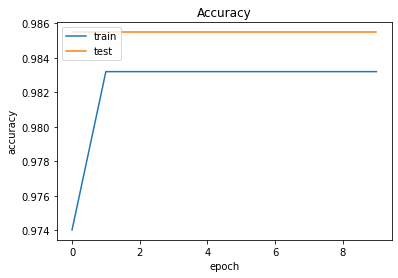

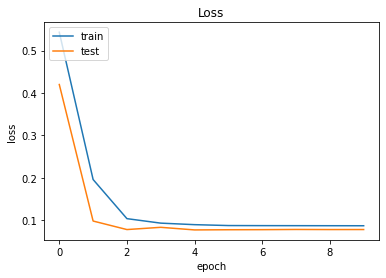

In [56]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()